In [29]:
import zipfile
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import random
import math
from itertools import permutations
import geopandas as gpd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
import xgboost as xgb

from copy import copy
import pickle

import pickle

# XGB Model

In [2]:
#loading data
taxi_train = pd.read_csv('data/train.csv')

## Data Preprocessing
The first step is to clean the data. I intend to train the model with both pick and drop off locations along with the pickup month, day, hour, and minute. Once again, I am using such a precise time element because it can account for weather and traffic which can be cyclical throughout the year. To make things eaiser/quicker I create a cleaning function which extracts and keeps only the information I need from the training dataset.

In [19]:
def clean_df(input_df):
    
    df = input_df
    
    #columns we want to keep
    col_list = ['pickup_longitude', 
        'pickup_latitude', 
        'dropoff_longitude', 
        'dropoff_latitude', 
        'trip_duration',
        'pickup_minute',
        'pickup_hour',
        'pickup_month',
        'pickup_day',
        'pickup_weekday']
    
    #changing datetime column to datetime class
    df['pickup_datetime_hold'] = pd.to_datetime(df['pickup_datetime'])
    
    #adding minute column
    df['pickup_minute'] = df.apply(lambda x: x.pickup_datetime_hold.minute, axis = 1) 

    #adding hour column
    df['pickup_hour'] = df.apply(lambda x: x.pickup_datetime_hold.hour, axis = 1) 

    #adding month column
    df['pickup_month'] = df.apply(lambda x: x.pickup_datetime_hold.month, axis = 1) 

    #adding day of month column
    df['pickup_day'] = df.apply(lambda x: x.pickup_datetime_hold.day, axis = 1) 

    #adding day of week column
    df['pickup_weekday'] = df.apply(lambda x: datetime.weekday(x.pickup_datetime_hold), axis = 1) 
    
    return(df[df.columns.intersection(col_list)])

In [6]:
taxi_train_clean = clean_df(taxi_train)

In [7]:
taxi_train_clean.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_minute,pickup_hour,pickup_month,pickup_day,pickup_weekday
0,-73.982155,40.767937,-73.964630,40.765602,455,24,17,3,14,0
1,-73.980415,40.738564,-73.999481,40.731152,663,43,0,6,12,6
2,-73.979027,40.763939,-74.005333,40.710087,2124,35,11,1,19,1
3,-74.010040,40.719971,-74.012268,40.706718,429,32,19,4,6,2
4,-73.973053,40.793209,-73.972923,40.782520,435,30,13,3,26,5


I put the data into a holding data frame so we can keep the original clean data intact for other purposes.

In [8]:
hold = taxi_train_clean

## Preparing the data for training
The next step is to split our data into our dependent and independent variables then split the set into training, validation, and testing sets.

In [10]:
#preparing dependent and independent variables
X = hold.drop(["trip_duration"], axis=1)
y = hold["trip_duration"]

In [52]:
#Split the data into training, test, and valdiation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1234)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 4321)

## Training the Model
In addition, I am using a mean squared log error for our evaluation function, used in most Kaggle competitions. As you can see from the model parameters below I chose to use a gradient boosted tree. The learning rate is the step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative. Subsample samples our training data randomly prior to growing trees to prevent overfitting. Maximum depth of the tree is 14. Alot of these paramters are a trial and error and have room to be further fine tuned for improvement.

Using this article: https://towardsdatascience.com/travel-time-optimization-with-machine-learning-and-genetic-algorithm-71b40a3a4c2 for setting up the gradient boosted model.

In [53]:
#grading mean squared log error
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [54]:
#XGBoost parameters 
params = {
    'booster':            'gbtree',
#     'objective':          'reg:squarederror',
    'objective':          'reg:linear',
    'learning_rate':      0.05,
    'max_depth':          14,
    'subsample':          0.9,
    'colsample_bytree':   0.7,
    'colsample_bylevel':  0.7,
    'silent':             1,
    'feval':              'rmsle'
}

Going through 2000 rounds and I am log transforming the trip_duration/y variable to adjust for some of our positive outliers. If you remember, our trip duration data was right skewed.

In [55]:
#setting the number of rounds
nrounds = 2500

In [56]:
#Define train and validation sets
dtrain = xgb.DMatrix(X_train, np.log(y_train+1))
dval = xgb.DMatrix(X_val, np.log(y_val+1))

#error tracking
watchlist = [(dval, 'eval'), (dtrain, 'train')]

In [1]:
#Train model
gbm = xgb.train(params,
                dtrain,
                num_boost_round = nrounds,
                evals = watchlist,
                verbose_eval = True
                )

## Model Evaluation
After training, we can evaluate the model using our testing data. I use both mean absolute error and mean squared error to see how accurate our model is as well as the feature scores. Note that everything was kept in seconds so our mean absolute error is a little below 5 minutes. 

In [58]:
#Test predictions
pred = np.exp(gbm.predict(xgb.DMatrix(X_test))) - 1

In [59]:
#mean absolute error
mae = (abs(pred - y_test)).mean()
mae

294.1531321177894

In [60]:
#mean squared error
mse = ((pred - y_test)**2).mean()
mse

58472689.27418018

Looking at the features, we can see which is weighted the highest which is the pickup and dropoff location as expected.

In [61]:
#feature scores
feature_scores = gbm.get_fscore()
feature_scores

{'dropoff_longitude': 1252751,
 'dropoff_latitude': 1311050,
 'pickup_latitude': 1379210,
 'pickup_minute': 809332,
 'pickup_month': 372883,
 'pickup_day': 637713,
 'pickup_longitude': 1491557,
 'pickup_weekday': 354872,
 'pickup_hour': 623950}

In [62]:
#scale feature scores
feat_sum = 0

for key in feature_scores:
    feat_sum= feat_sum + feature_scores[key]

for key in feature_scores:
    feature_scores[key] = feature_scores[key] / feat_sum

feature_scores

{'dropoff_longitude': 0.15215627527079606,
 'dropoff_latitude': 0.15923713866025824,
 'pickup_latitude': 0.16751569658793697,
 'pickup_minute': 0.09829961626649183,
 'pickup_month': 0.04528951754323105,
 'pickup_day': 0.07745516449139946,
 'pickup_longitude': 0.18116110661582607,
 'pickup_weekday': 0.04310194261900245,
 'pickup_hour': 0.07578354194505788}

# Genetic Algorithm
A genetic algorithm works when we have a population. Each member of the population have a certain fitness score and depending on that fitness score determines how often they will breed. After we have a set of parents we cross them and create a new set of children which is then the next generation. The idea is doing this enough times, we will get the highest fitness population in the end after a certain amount of generations. 

We will be using method to help determine the optimal order in which to pickup packages/passengers given a series of locations. Using our trained model to predict the total time of the trip.

## Auxiliary Functions
The next step is to create auxiliary functions for our genetic algorithm.

The convert function breaks the seconds down into hours, minutes, seconds, and seconds. We will use this to add time to our initial start time after reaching our first pickup location to get the most accurate trip duration.

In [1]:
#converting seconds into hour, minutes, seconds, microseconds
def convert(start_time, add): 
    add = add % (24 * 3600) 
    hour = add // 3600
    add %= 3600
    minutes = add // 60
    add %= 60
      
    return(start_time + timedelta(seconds=add, minutes=minutes, hours=hour)) 

The next two functions simply set up our data ready to be inputted into the model we trained to predict the trip duration

In [2]:
#setup function to only keep columns we want
def setup(x):
    hold = pd.concat([x, x.shift(-1)], axis = 1).dropna()
    hold.columns = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'] 
    return(hold)

In [3]:
#prepare dataframe to be inputted into model
def set_model_input(x, ind, time):
    hold = x.iloc[ind].to_frame().T
    hold['pickup_datetime'] = time
    return(clean_df(hold))

Next is a total time function which will return the total time of a trip after visiting an inputted amount of checkpoints. We want to minimize this time in the genetic algorithm. It will also be used as our fitness score to choose parents for the children.

In [4]:
#return total time of a set of trips
def get_total_time(x, start_time):
    
    #setting up intial input df, time, and holding array
    temp = setup(x)
    start_time_hold = start_time
    time_total = [0] * len(temp)
    
    for i in range(len(temp)):
        hold = set_model_input(temp, i, start_time_hold)
        trip_dur = (np.exp(model.predict(xgb.DMatrix(hold))) - 1)[0]
        time_total[i] = trip_dur
        start_time_hold = convert(start_time_hold, trip_dur)
        
    return(sum(time_total))

The next series of functions will create a random intial population. In this case it creates a series of random orders of our locations to start. We then rank each of these route orders using the total trip duration function. Afterwards they are ranked from the trip duration, giving a higher rank to those which have shorter duration times. The rank is then used to calculate a probability of it being chosen as a parent for the next generation (higher rank = higher chance of becoming a parent). After creating two sets of parents we cross them. Half of the points chosen at random in one set of parents are kept and the other half will be filled from the other set of parents. If the gap is filled with a number already in the set, it will be filled with a random point that is available so that in the end each child is still contains one of each pickup location. 

In [5]:
#get intial population for GA
def get_init_pop(x, num):
    
    hold = []
    pop = list(range(x))
    
    for i in range(num):
        hold.append((random.sample(pop,x)))
        
    return(hold)

In [6]:
#prepare/rank intial population
def rank(input_pop, orig_pts, datetime):
    
    hold_df = pd.DataFrame(input_pop)
    
    total_time_hold = [0] * len(input_pop)
    
    for i in range(len(input_pop)):
        total_time_hold[i] = get_total_time(orig_pts.reindex(input_pop[i]), datetime)
    
    #add total time column / fitness 
    hold_df['total_time'] = total_time_hold
    
    #add rank column which gives the highest rank to the combination with the lowest total trip duration
    hold_df['rank'] = len(hold_df) - hold_df['total_time'].rank() + 1
    
    #add chance column which uses rank to calculate probability of being chosen as a parent
    ##higher fitness means higher chance of breeding
    hold_df['chance'] = hold_df['rank']*2/(len(hold_df)*(len(hold_df)+1))
    
    return(hold_df)   

In [7]:
#choose a set parents from our population based on the fitness
##parents shouls be equal 
def get_parent(input_df):
    pop_size = len(input_df)
    which_parent = np.random.choice(pop_size, pop_size, p = input_df['chance'])
    num_chrom = len(list(set(input_df.columns) - set(['total_time', 'rank', 'chance'])))
    parent = input_df.reindex(which_parent).iloc[:,:num_chrom].to_numpy()
    return(parent)

In [8]:
#cross parent chromosomes
def cross(parent1, parent2):
    
    #how many chromosomes we want to keep from each parent
    num_parent = len(parent1)
    num_chrom = len(parent1[0])
    num_one = math.ceil(num_chrom/2)
    num_zero = num_chrom - math.ceil(num_chrom/2) #safer option than using floor
    
    chrom_filter_source = ([1] * num_one) + ([0]*num_zero)
    
    #create #create a "filter" for our chromosomes
    chrom_filter = []
    for i in range(num_parent):
        chrom_filter.append((random.sample(chrom_filter_source, num_chrom)))
        
    #create opposite filter for our second parent
    chrom_filter2 = abs(np.subtract(chrom_filter, 1))
    
    #need to add 1 because our lowest number right now is 0 if left alone when filtered, we will have multipl 0's
    new_parent1 = np.multiply(np.add(parent1,1), chrom_filter)  
    new_parent2 = np.multiply(np.add(parent2,1), chrom_filter2)
    
    #loop through all parents and cross chromosomes
    for i in range(num_parent):
        #only look at couples with matching chromosomes
        if(any(x in new_parent1[i] for x in new_parent2[i])):
            #available chromosomes to choose from to fill gaps
            not_set = list(set(list(range(num_chrom+1))[1:]) - set(new_parent1[i] + new_parent2[i]))
            #fill gaps
            for idx, j in enumerate(new_parent2[i]):
                if (j in new_parent1[i] and j != 0):
                    insert = random.sample(not_set, 1)[0]
                    new_parent1[i,idx] = insert
                    new_parent2[i,idx] = 0
                    not_set.remove(insert) #once a chromosome is used remove it from possible choices
    
    #add them together as a cross
    return(np.add(new_parent1, new_parent2))

In [9]:
#getting the next generation
def get_next_gen(input_df):
    p1 = get_parent(input_df)
    p2 = get_parent(input_df)
    next_gen = np.subtract(cross(p1, p2),1)
    return(next_gen)

# Final GA Function

The final function now maps through the entire process of getting the next generation a set number of times. The get optimal order function takes in a dataframe of locations (lattitude and longitude), an initial population size, and the number of generations to run through, returning the top 3 orders in the end. 

In [10]:
#this is a supplmentary function which will help with our threshold
def condense (input_df):
    return(input_df.groupby(list(set(input_df.columns) - set(['rank', 'chance']))).sum().reset_index())

In [11]:
def get_optimal_order(input_df, date, init_pop_size, gens):
    #timer
    start_time = datetime.now()
    
    #getting initial population
    init_pop =  get_init_pop(len(input_df), init_pop_size)
    
    for i in range(gens - 1):
        #ranking the population
        ranked = rank(init_pop, input_df, date)
        
        best = ranked.sort_values(by=['rank'], ascending=False).iloc[0] 
    
        #creating next generation
        next_gen = get_next_gen(ranked)
        init_pop = next_gen
    
    final_gen = condense(rank(next_gen, input_df, date))
    
    end_time = datetime.now()
    print(end_time - start_time)
    
    return(final_gen.iloc[:3])

# Example
So now I load our testing data for the example. I randomly choose 5 rows and take the pickup location as example set. We also need an example date to start as well.

In [14]:
taxi_test = pd.read_csv('data/test.csv')

In [15]:
#load model that we trained
model = pickle.load(open('xgb_model.sav', 'rb'))

[23:22:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


In [16]:
#Sample locations
np.random.seed(seed=4321)
test_set_idx = np.random.choice(len(taxi_test),5)
test_set = taxi_test.iloc[test_set_idx].reset_index()[['pickup_longitude', 'pickup_latitude']]

#Sample date
test_date = datetime(2020, 5, 17, 17)

In [17]:
test_set

,pickup_longitude,pickup_latitude
0,-73.993599,40.747028
1,-73.863625,40.769852
2,-73.990532,40.751259
3,-73.991287,40.750370
4,-74.014709,40.714329


The first step is to create a validation. I create a set of all the permutations of the order to visit the locations and return the order with the shortest time. This is what we want to get from our genetic algorithm.

In [81]:
perm = list(permutations(list(test_set.index))) 
test_full = rank(perm, test_set, test_date)
test_full_ranked = test_full.sort_values(by=['rank'], ascending=False)
test_full_ranked.iloc[0]

0                4.000000
1                2.000000
2                3.000000
3                0.000000
4                1.000000
total_time    3468.165573
rank           120.000000
chance           0.016529
Name: 112, dtype: float64

In [88]:
get_optimal_order(test_set, test_date, 100, 20)

0:02:23.134802


,0,1,2,3,4,total_time,rank,chance
0,4,2,3,0,1,3468.165573,5050.0,1.0


Running it looks like we get the correct results and shows that the Genetic Algorithm works. The chance column means that by the end of 20 generations the entire population was 42301 ordering meaning it was the highest fitness and as the generations passed it was chosen as a parent more often so it's characteristics (the order in this context) were passed on to the next generation slowly weeding out less efficient routes.

In [20]:
output = get_optimal_order(test_set, test_date, 100, 20)

0:06:38.071338


In [41]:
output
list(output.iloc[:,0:len(output.columns) - 3].loc[0])

[4, 2, 3, 0, 1]

In [31]:
test_set

,pickup_longitude,pickup_latitude
0,-73.993599,40.747028
1,-73.863625,40.769852
2,-73.990532,40.751259
3,-73.991287,40.750370
4,-74.014709,40.714329


In [42]:
plot_dat = test_set.reindex(list(output.iloc[:,0:len(output.columns) - 3].loc[0]))
plot_dat

,pickup_longitude,pickup_latitude
4,-74.014709,40.714329
2,-73.990532,40.751259
3,-73.991287,40.750370
0,-73.993599,40.747028
1,-73.863625,40.769852


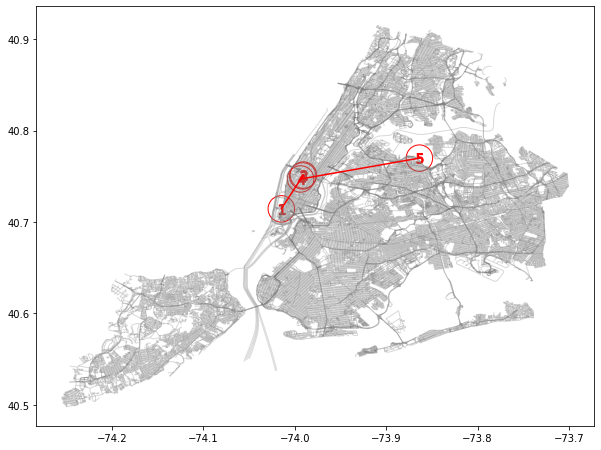

In [45]:
street_map = gpd.read_file('shp/geo_export_0a23a24b-8a75-4a43-b238-df5c9996dcf4.shp')
fig, ax = plt.subplots(figsize=(10,10))

#Plotting city streets
street_map.plot(ax = ax, alpha = 0.3, color = 'grey', linewidth=1)

#setting cutom markers for each point
x = plot_dat['pickup_longitude']
y = plot_dat['pickup_latitude']
markers = ["$1$", "$2$", "$3$", "$4$", "$5$"]

#plot results in optimized order
plt.plot( x, y, linestyle='-', color = 'red')

for  xp, yp, m in zip(x, y, markers):
    plt.scatter([xp], [yp], marker=m, s = 100, color = 'red')
    plt.scatter([xp], [yp], marker='o', s = 700, facecolors='none', edgecolors='r')

plt.show()